In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import wandb
from tqdm import tqdm
import os
import functools

In [3]:
def create_activation_function(activation_name):
  """Create and return the specified activation function."""
  activation_mapping = {
      'relu': nn.ReLU(),
      'leaky_relu': nn.LeakyReLU(0.1),
      'gelu': nn.GELU()
  }
  return activation_mapping.get(activation_name, nn.ReLU())

In [4]:
def build_convolutional_block(in_channels, out_channels, kernel_size,use_batchnorm, dropout_rate, activation_fn):
    """Construct a convolutional block with optional batchnorm and dropout."""
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size, padding='same'),
        activation_fn
    ]

    if use_batchnorm:
        layers.append(nn.BatchNorm2d(out_channels))

    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    if dropout_rate > 0:
        layers.append(nn.Dropout(dropout_rate))

    return nn.Sequential(*layers)

In [5]:
def calculate_flattened_size(conv_blocks, input_shape):
    """Calculate the flattened size after convolutional layers."""
    with torch.no_grad():
        dummy = torch.zeros(1, input_shape[2], input_shape[0], input_shape[1])
        for block in conv_blocks:
            dummy = block(dummy)
        return dummy.view(1, -1).shape[1]

In [6]:
def build_dense_layers(flattened_size, dense_units, dropout_rate, activation_fn, num_classes):
    """Construct dense layers with optional dropout."""
    layers = [nn.Flatten()]
    prev_size = flattened_size

    for units in dense_units:
        layers.extend([
            nn.Linear(prev_size, units),
            activation_fn
        ])
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))
        prev_size = units

    layers.append(nn.Linear(prev_size, num_classes))
    return nn.Sequential(*layers)

In [7]:
# Create forward function
def forward_pass(x, conv_blocks, dense_block):
    for block in conv_blocks:
        x = block(x)
    return dense_block(x)

In [8]:
def create_vision_network(config, input_shape=(224, 224, 3), num_classes=10):
    """Create a vision neural network based on configuration parameters."""
    # Extract configuration parameters
    conv_filters = config.get('conv_filters', [32, 32, 32, 32, 32])
    kernel_sizes = config.get('kernel_sizes', [3, 3, 3, 3, 3])
    dense_units = config.get('dense_units', [128])
    dropout_rate = config.get('dropout_rate', 0.2)
    use_batchnorm = config.get('use_batchnorm', True)
    activation_name = config.get('activation', 'relu')

    # Create activation function
    activation_fn = create_activation_function(activation_name)

    # Build convolutional blocks
    conv_blocks = []
    in_channels = input_shape[2]

    for i in range(len(conv_filters)):
        apply_dropout = (i < len(conv_filters) - 1) and (dropout_rate > 0)
        block = build_convolutional_block(
            in_channels,
            conv_filters[i],
            kernel_sizes[i],
            use_batchnorm,
            dropout_rate if apply_dropout else 0,
            activation_fn
        )
        conv_blocks.append(block)
        in_channels = conv_filters[i]

    # Calculate flattened size
    flattened_size = calculate_flattened_size(conv_blocks, input_shape)

    # Build dense layers
    dense_block = build_dense_layers(
        flattened_size,
        dense_units,
        dropout_rate,
        activation_fn,
        num_classes
    )



    # Create a complete model
    model = nn.Module()
    model.conv_blocks = nn.ModuleList(conv_blocks)
    model.dense_block = dense_block
    model.forward = functools.partial(forward_pass, conv_blocks=model.conv_blocks, dense_block=model.dense_block)

    return model

In [9]:
def prepare_transforms(augment=False):
    """Prepare image transformations for training and validation."""
    base_transforms = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]

    if augment:
        train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            *base_transforms
        ])
    else:
        train_transforms = transforms.Compose(base_transforms)

    test_transforms = transforms.Compose(base_transforms)

    return train_transforms, test_transforms

In [10]:
def load_and_split_dataset(data_dir, train_transform, test_transform, val_split=0.2):
    """Load dataset and split into train, validation, and test sets."""
    # Load datasets
    train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
    test_dataset = ImageFolder(os.path.join(data_dir, 'val'), transform=test_transform)

    # Split train into train and validation
    val_size = int(val_split * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

    return train_subset, val_subset, test_dataset, train_dataset.classes

In [11]:
def create_data_loaders(train_data, val_data, test_data, batch_size=32):
    """Create data loaders for training, validation, and testing."""
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [12]:
def prepare_data(data_dir, batch_size=32, val_split=0.2, augment=False):
    """Prepare data loaders for training, validation, and testing."""
    # Prepare transforms
    train_transform, test_transform = prepare_transforms(augment)

    # Load and split dataset
    train_data, val_data, test_data, classes = load_and_split_dataset(
        data_dir, train_transform, test_transform, val_split
    )

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        train_data, val_data, test_data, batch_size
    )

    return train_loader, val_loader, test_loader, classes

In [13]:
def evaluate_model(model, data_loader, loss_fn, device):
    """Evaluate model on the given data loader."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Calculate metrics
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

In [14]:
def train_epoch(model, train_loader, optimizer, loss_fn, device):
    """Train model for one epoch."""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, unit="batch") as progress_bar:
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate metrics
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * correct / total:.1f}%'
            })

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

In [15]:
def train_and_validate(config=None):
    """Train and validate model with the given configuration."""
    with wandb.init(config=config) as run:
        config = wandb.config

        # Set descriptive run name
        run.name = (f"filters_{'-'.join(map(str, config.conv_filters))}_"
                   f"dense_{'-'.join(map(str, config.dense_units))}_"
                   f"lr_{config.learning_rate:.0e}_"
                   f"bs_{config.batch_size}")

        # Prepare data
        train_loader, val_loader, _, classes = prepare_data(
            data_dir='/kaggle/input/nature-12k/inaturalist_12K',
            batch_size=config.batch_size,
            augment=config.data_augmentation
        )

        # Create model
        model = create_vision_network(
            {
                'conv_filters': config.conv_filters,
                'kernel_sizes': config.kernel_sizes,
                'dense_units': config.dense_units,
                'dropout_rate': config.dropout_rate,
                'use_batchnorm': config.use_batchnorm,
                'activation': config.activation
            },
            num_classes=len(classes)
        )

        # Set device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)

        # Initialize optimizer and loss function
        optimizer = optim.Adam(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        loss_fn = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(1, 21):  # Fixed 20 epochs
            # Train for one epoch
            train_loss, train_acc = train_epoch(
                model, train_loader, optimizer, loss_fn, device
            )

            # Validate
            val_loss, val_acc = evaluate_model(
                model, val_loader, loss_fn, device
            )

            # Log metrics
            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc
            })

In [16]:
def setup_sweep_config():
    """Set up configuration for hyperparameter sweep."""
    return {
        'method': 'bayes',
        'metric': {'name': 'val_acc', 'goal': 'maximize'},
        'parameters': {
            'conv_filters': {
                'values': [
                    [32, 32, 32, 32, 32],
                    [64, 64, 64, 64, 64],
                    [16, 32, 64, 128, 256],
                    [256, 128, 64, 32, 16]
                ]
            },
            'kernel_sizes': {
                'values': [
                    [3, 3, 3, 3, 3],
                    [5, 5, 5, 5, 5],
                    [3, 5, 3, 5, 3]
                ]
            },
            'dense_units': {
                'values': [
                    [64],
                    [128],
                    [64, 128],
                    [256, 128]
                ]
            },
            'learning_rate': {
                'values': [1e-3, 1e-4]
            },
            'weight_decay': {
                'values': [0, 0.0001, 0.001, 0.01]
            },
            'dropout_rate': {
                'values': [0.0, 0.2, 0.3, 0.5]
            },
            'use_batchnorm': {
                'values': [True, False]
            },
            'batch_size': {
                'values': [32, 64, 128]
            },
            'data_augmentation': {
                'values': [True, False]
            },
            'activation': {
                'values': ['relu', 'leaky_relu', 'gelu']
            }
        }
    }

In [ ]:
def main():
    """Main function to run the hyperparameter sweep."""
    # Initialize wandb
    wandb.login(key="49f8f505158ee3693f0cacf0a82118bd4e636e8c")

    # Set up sweep configuration
    sweep_config = setup_sweep_config()

    # Create and run sweep
    sweep_id = wandb.sweep(sweep_config, project='DA6401_A2')
    wandb.agent(sweep_id, function=train_and_validate, count=30)

if __name__ == '__main__':
    main()

In [17]:
def test_best_model(best_config):
    """Test the best model configuration on the test dataset."""
    # Prepare data loaders with best configuration
    train_loader, val_loader, test_loader, classes = prepare_data(
        data_dir='/kaggle/input/nature-12k/inaturalist_12K',
        batch_size=best_config['batch_size'],
        augment=best_config['data_augmentation']
    )

    # Create model with best configuration
    model = create_vision_network({
        'conv_filters': best_config['conv_filters'],
        'kernel_sizes': best_config['kernel_sizes'],
        'dense_units': best_config['dense_units'],
        'dropout_rate': best_config['dropout_rate'],
        'use_batchnorm': best_config['use_batchnorm'],
        'activation': best_config['activation']
    }, num_classes=len(classes))

    # Set up device and move model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Initialize optimizer and loss function
    optimizer = optim.Adam(
        model.parameters(), 
        lr=best_config['learning_rate'],
        weight_decay=best_config['weight_decay']
    )
    loss_fn = nn.CrossEntropyLoss()

    # # Train the model first (optional)
    for epoch in range(20):
        train_epoch(model, train_loader, optimizer, loss_fn, device)

    # Evaluate on test set
    test_loss, test_acc = evaluate_model(model, test_loader, loss_fn, device)
    print(f"\nFinal Test Results using Best Config:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    return test_loss, test_acc


In [18]:
best_config = {
    "conv_filters": [64, 64, 64, 64, 64],
    "kernel_sizes": [3, 3, 3, 3, 3],
    "dense_units": [64, 128],
    "learning_rate": 1e-3,
    "weight_decay": 0.0001,
    "dropout_rate": 0.0,
    "use_batchnorm": True,
    "batch_size": 128,
    "data_augmentation": True,
    "activation": "gelu"
}

test_loss, test_acc = test_best_model(best_config)

100%|██████████| 63/63 [00:38<00:00,  1.63batch/s, loss=1.5851, acc=45.0%]



Final Test Results using Best Config:
Test Loss: 1.7200
Test Accuracy: 41.50%


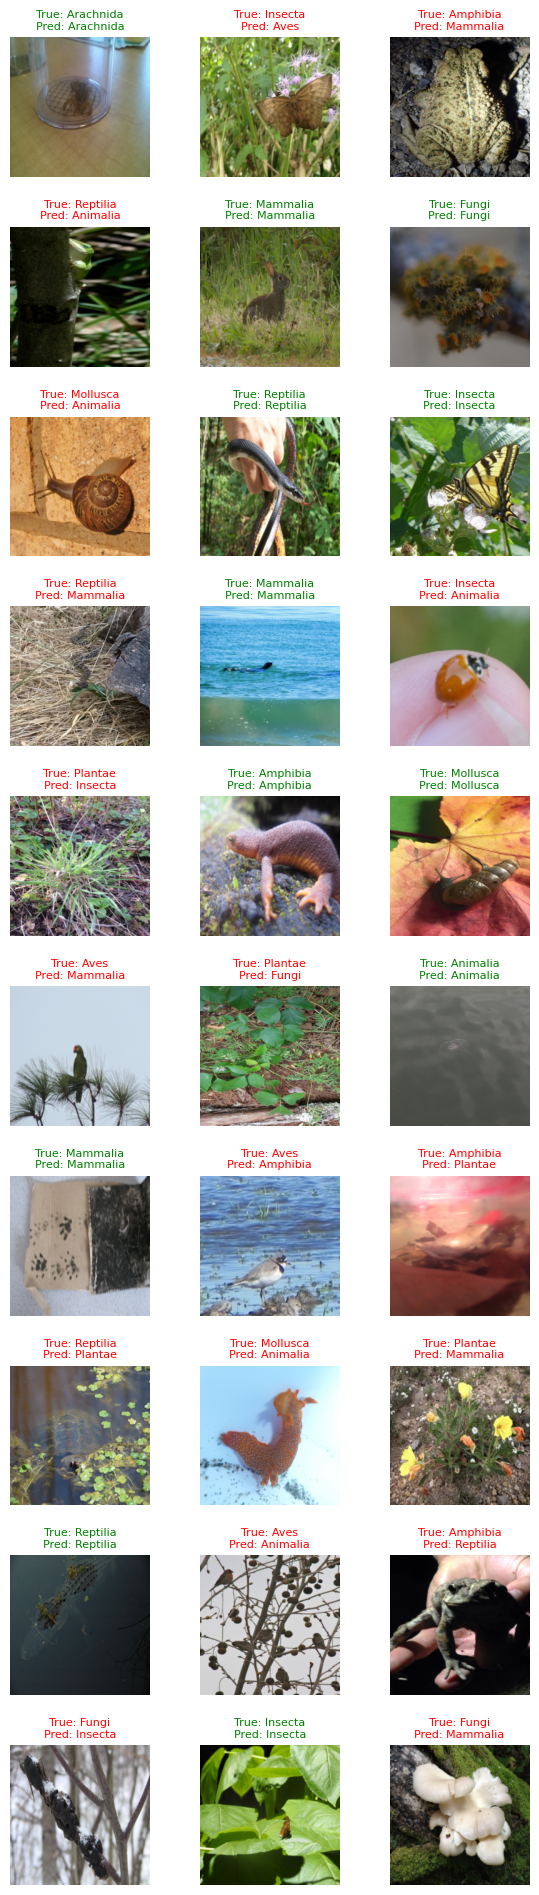

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid  # Also needed for ImageGrid

def plot_prediction_grid(test_loader, classes, best_config, num_rows=10, num_cols=3):
    """Create a grid of test images with predictions."""
    # Load best model
    model = create_vision_network({
        'conv_filters': best_config['conv_filters'],
        'kernel_sizes': best_config['kernel_sizes'],
        'dense_units': best_config['dense_units'],
        'dropout_rate': best_config['dropout_rate'],
        'use_batchnorm': best_config['use_batchnorm'],
        'activation': best_config['activation']
    }, num_classes=len(classes))
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Collect samples
    images, true_labels, pred_labels = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            images.extend(inputs.cpu())
            true_labels.extend(labels.cpu())
            pred_labels.extend(preds.cpu())

    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    denormalize = transforms.Normalize((-mean/std).tolist(), (1.0/std).tolist())

    # Create grid
    fig = plt.figure(figsize=(15, 40))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.4)

    # Plot images with predictions
    for ax, idx in zip(grid, range(num_rows*num_cols)):
        img = denormalize(images[idx])
        true = true_labels[idx].item()
        pred = pred_labels[idx].item()
        
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
        
        color = "green" if true == pred else "red"
        ax.set_title(f"True: {classes[true]}\nPred: {classes[pred]}", 
                    color=color, fontsize=9)

    plt.show()

# Usage
train_loader, val_loader, test_loader, classes = prepare_data(
    data_dir='/kaggle/input/nature-12k/inaturalist_12K',
    batch_size=best_config['batch_size'],
    augment=False
)

plot_prediction_grid(train_loader, classes, best_config)